# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image
import gc

from socket import timeout

#from google.colab import files

# !pip3 install -q torch torchvision
# !pip3 install -q Pillow

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [2]:
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

--2021-10-24 23:11:46--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  46.1MB/s    in 14s     

2021-10-24 23:12:02 (37.2 MB/s) - ‘train.zip’ saved [562348083/562348083]

--2021-10-24 23:12:07--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.188.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>] 

In [3]:
train_folder = "train_kaggle/"
test_folder = "test_kaggle/"

In [4]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!

In [5]:
torch.cuda.is_available()

True

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

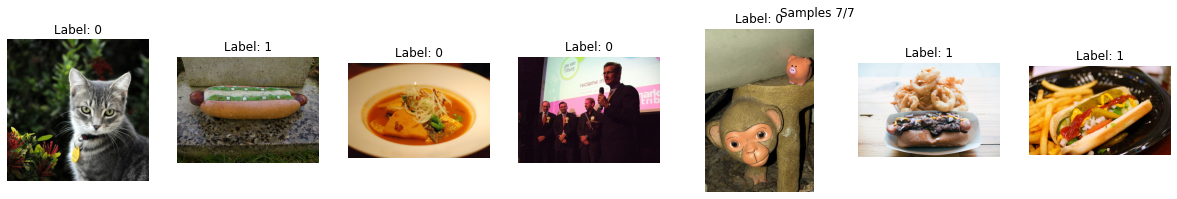

In [6]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.images = os.listdir(folder)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        img_path = os.path.join(self.folder, self.images[index])
        img_id = os.path.splitext(self.images[index])[0]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        y = False
        starts = ['frankfurter', 'chili-dog', 'hotdog']
        for start in starts:
            y = y or img_id.startswith(start)
        y = (1 if y else 0)
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   
    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

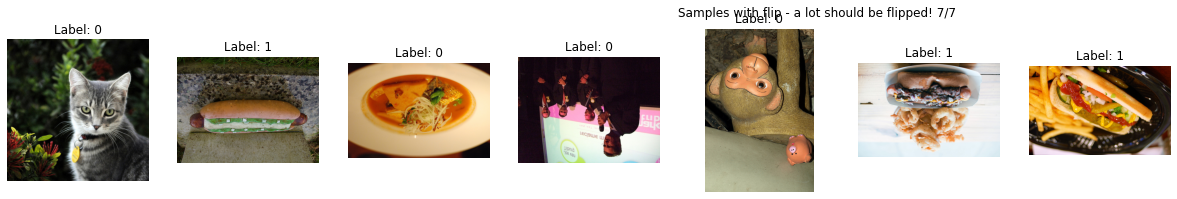

In [7]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [8]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [9]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [10]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    
    return float(correct_samples) / total_samples 

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [11]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2

def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}

classes = load_imagenet_classes()
# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


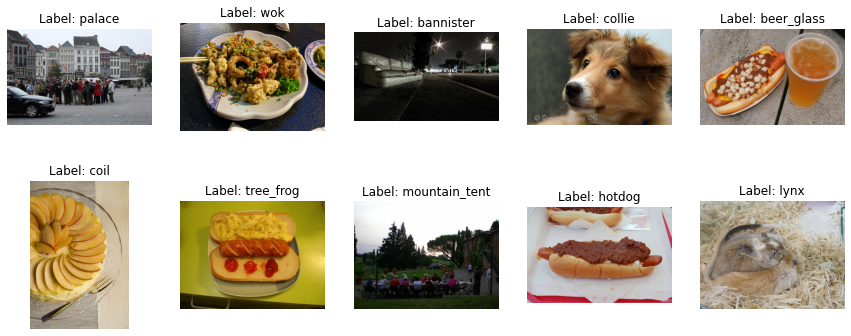

In [12]:
model = models.resnet18(pretrained=True)

count=10
indices = np.random.choice(len(orig_dataset), count, replace=False)

train_transform = transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])

plt.figure(figsize=(5*3,2*3))

images = []
for index in indices:
    img, _, _ = orig_dataset[index]
    images.append(torch.unsqueeze(train_transform(img), dim=0))
batch = torch.cat(images)
_, predicted_class_indices = torch.max(model(batch), 1)
for i, index in enumerate(indices):    
    x, _, _ = orig_dataset[index]
    plt.subplot(2, 5, i+1)
    plt.title("Label: %s" % classes[int(predicted_class_indices[i])])
    plt.imshow(x)
    plt.grid(False)
    plt.axis('off') 

del model

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [13]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

for parameter in model.parameters():
    parameter.requires_gradient = False

in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat, 2)
model = model.to(device)
parameters = model.fc.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.369570, Train accuracy: 0.830844, Val accuracy: 0.911957
Average loss: 0.219869, Train accuracy: 0.919359, Val accuracy: 0.939130


# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [14]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat, 2)
model = model.to(device)

parameters = model.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( parameters, lr=0.001, momentum=0.9)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.305710, Train accuracy: 0.863427, Val accuracy: 0.950000
Average loss: 0.143941, Train accuracy: 0.947597, Val accuracy: 0.948913
Average loss: 0.098634, Train accuracy: 0.968232, Val accuracy: 0.955435
Average loss: 0.070390, Train accuracy: 0.980451, Val accuracy: 0.954348
Average loss: 0.049127, Train accuracy: 0.986696, Val accuracy: 0.954348


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [15]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
loss = nn.CrossEntropyLoss()

in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat, 2)

model = model.to(device)

optimizer = optim.Adam([{'params': model.fc.parameters(), 'lr':1e-3}], lr=1e-4, weight_decay=0.8) # Hint - look into what PyTorch optimizers let you configure!
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.314850, Train accuracy: 0.877545, Val accuracy: 0.929348
Average loss: 0.223526, Train accuracy: 0.930763, Val accuracy: 0.931522
Average loss: 0.227106, Train accuracy: 0.924518, Val accuracy: 0.938043
Average loss: 0.222764, Train accuracy: 0.925876, Val accuracy: 0.920652
Average loss: 0.224109, Train accuracy: 0.927233, Val accuracy: 0.939130


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [16]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=SubsetSampler(indices))
    
    predictions = []
    ground_truth = []
    for i, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        prediction = model(x_gpu)
        _, prediction = torch.max(prediction, dim=1)
        prediction = prediction.cpu()
        prediction = prediction.data.numpy()
        prediction = (prediction == 1)
        predictions.append(prediction)
        ground_truth.append(y.data.numpy() == 1)
    
    predictions = np.concatenate(predictions, axis=0)
    ground_truth = np.concatenate(ground_truth, axis=0)
    return predictions, ground_truth

gc.collect()
predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

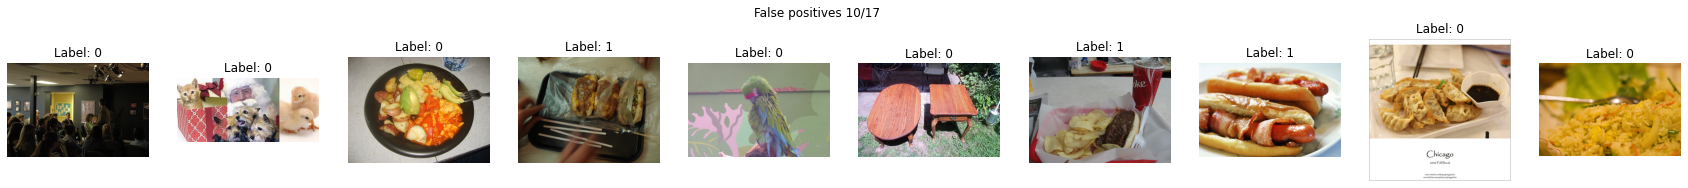

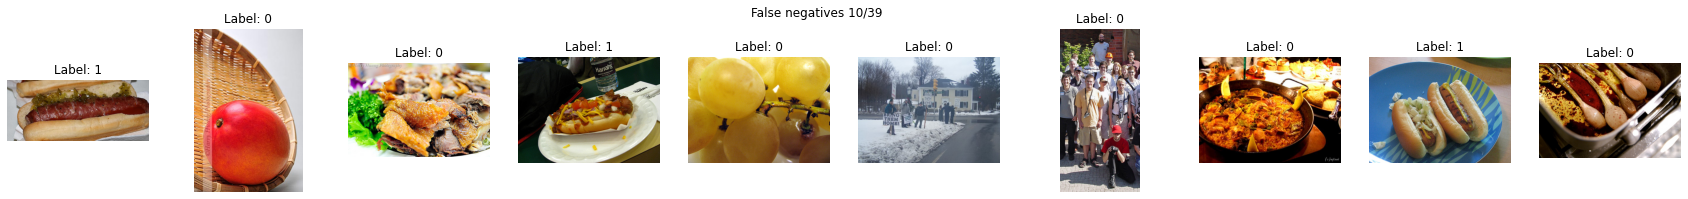

In [17]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = np.argwhere((predictions == True) & (gt == False)).squeeze(axis=1)
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = np.argwhere((predictions == False) & (gt == True)).squeeze(axis=1)
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [18]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    precision = np.sum(prediction == ground_truth) / prediction.shape[0]
    TP = np.sum((prediction == True) & (ground_truth == True))
    FN = np.sum((prediction == False) & (ground_truth == True))
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.899, P: 0.939, R: 0.862


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [19]:
import torch.nn as nn
import torch.optim as optim

model = models.resnet18(pretrained=True)
loss = nn.CrossEntropyLoss()

in_feat = model.fc.in_features
model.fc = nn.Linear(in_feat, 2)

model = model.to(device)

optimizer = optim.Adam([{'params': model.fc.parameters(), 'lr':1e-3}], lr=1e-4, weight_decay=0.8) # Hint - look into what PyTorch optimizers let you configure!
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 10)

best_model = model

Average loss: 0.326931, Train accuracy: 0.863155, Val accuracy: 0.935870
Average loss: 0.230761, Train accuracy: 0.920988, Val accuracy: 0.939130
Average loss: 0.216487, Train accuracy: 0.930220, Val accuracy: 0.939130
Average loss: 0.220237, Train accuracy: 0.929948, Val accuracy: 0.936957
Average loss: 0.223363, Train accuracy: 0.929134, Val accuracy: 0.936957
Average loss: 0.223149, Train accuracy: 0.926690, Val accuracy: 0.939130
Average loss: 0.214197, Train accuracy: 0.934564, Val accuracy: 0.938043
Average loss: 0.223174, Train accuracy: 0.925604, Val accuracy: 0.931522
Average loss: 0.222674, Train accuracy: 0.924518, Val accuracy: 0.933696
Average loss: 0.226786, Train accuracy: 0.928048, Val accuracy: 0.936957


F1: 0.937, P: 0.837, R: 0.884


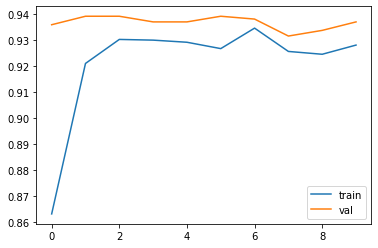

In [20]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

# TODO: Visualize training curve for the best model
plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

## Визуализируйте ошибки лучшей модели

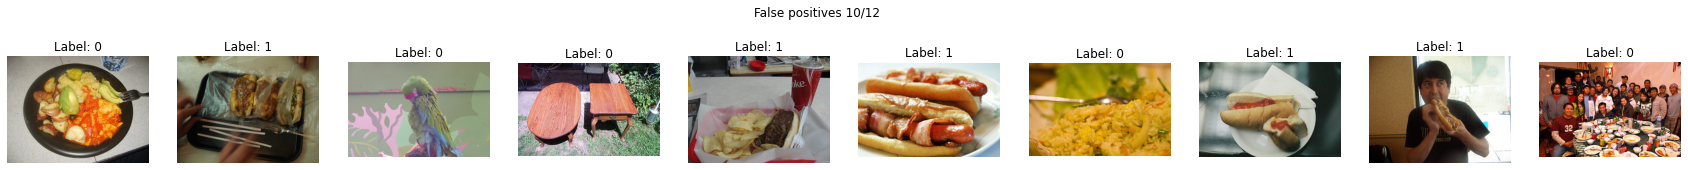

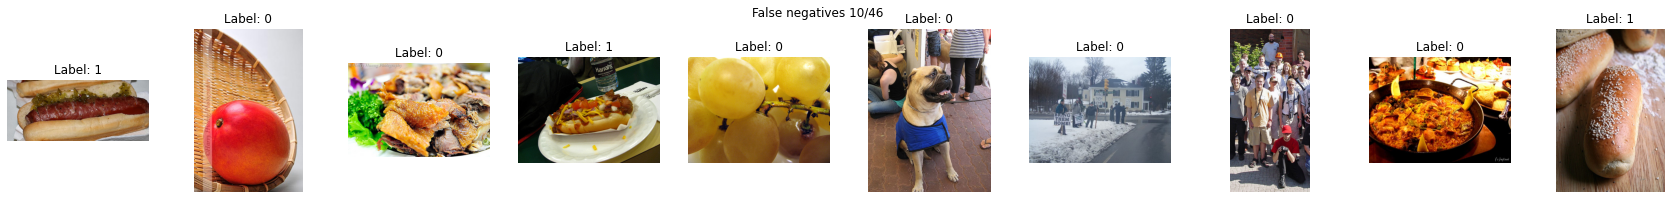

In [21]:
# TODO Visualize false positives and false negatives of the best model on the validation set
gc.collect()
predictions, gt = evaluate_model(model, train_dataset, val_indices)

false_positive_indices = np.argwhere((predictions == True) & (gt == False)).squeeze(axis=1)
visualize_samples(orig_dataset, false_positive_indices, "False positives")

false_negatives_indices = np.argwhere((predictions == False) & (gt == True)).squeeze(axis=1)
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")